# Recession-Proof Stock Screener

Find low-value stocks with positive long-term trends in recession-resistant sectors.

**22 Categories covering 150+ stocks:**
- **Utilities:** Electric, Water
- **Consumer Defensive:** Staples, Food & Beverage, Household Products, Grocery
- **Retail:** Discount Retail
- **Healthcare:** General, Pharmaceuticals, Health Insurance
- **Telecom:** Communication Services
- **REITs:** Healthcare, Residential, Essential/Triple-Net
- **Financial:** Insurance, Regional Banks
- **Infrastructure:** Waste Management, Defense/Aerospace, Railroads, Infrastructure
- **Energy:** Midstream/Pipelines
- **Precious Metals:** Gold Miners
- **Income:** Dividend Aristocrats
- **Alternative:** Sin Stocks

In [1]:
# Install dependencies
!pip install yfinance pandas numpy -q

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Recession-proof sector categories
SECTORS = {
    # Defensive Utilities
    "utilities": ["NEE", "DUK", "SO", "D", "AEP", "XEL", "ES", "WEC", "ED", "EIX"],
    "water_utilities": ["AWK", "WTR", "WTRG", "SJW", "AWR", "CWT", "MSEX", "YORW"],

    # Consumer Defensive
    "consumer_staples": ["PG", "KO", "PEP", "WMT", "COST", "CL", "KMB", "GIS", "K", "HSY"],
    "food_beverage": ["KO", "PEP", "MDLZ", "KHC", "GIS", "CPB", "SJM", "CAG", "HRL", "TSN"],
    "household_products": ["PG", "CL", "CHD", "CLX", "KMB", "SPB", "EPC", "CENT"],

    # Retail
    "discount_retail": ["WMT", "COST", "DG", "DLTR", "TJX", "ROST", "BJ", "OLLI", "FIVE", "PSMT"],
    "grocery": ["KR", "ACI", "SFM", "GO", "NGVC", "WMK", "VLGEA"],

    # Healthcare
    "healthcare": ["JNJ", "UNH", "PFE", "MRK", "ABBV", "LLY", "BMY", "AMGN", "GILD", "CVS"],
    "pharmaceuticals": ["PFE", "MRK", "ABBV", "LLY", "BMY", "AMGN", "GILD", "VTRS", "TAK", "NVO"],
    "health_insurance": ["UNH", "ELV", "CI", "HUM", "CNC", "MOH"],

    # Telecom & Communication
    "telecom": ["T", "VZ", "TMUS", "CMCSA", "CHTR"],

    # Real Estate (Defensive REITs)
    "reits_healthcare": ["WELL", "VTR", "OHI", "PEAK", "HR", "DOC", "SBRA", "LTC"],
    "reits_residential": ["AVB", "EQR", "ESS", "MAA", "UDR", "CPT", "INVH", "AMH"],
    "reits_essential": ["O", "WPC", "NNN", "ADC", "STOR", "FCPT", "EPRT"],

    # Financial (Defensive)
    "insurance": ["BRK-B", "PGR", "ALL", "TRV", "CB", "MET", "PRU", "AFL", "AIG", "HIG"],
    "regional_banks": ["USB", "PNC", "TFC", "FITB", "RF", "KEY", "CFG", "MTB", "HBAN"],

    # Infrastructure & Industrial
    "waste_management": ["WM", "RSG", "WCN", "CWST", "GFL", "CLH", "SRCL"],
    "defense_aerospace": ["LMT", "RTX", "NOC", "GD", "BA", "LHX", "HII", "TXT", "LDOS"],
    "railroads": ["UNP", "CSX", "NSC", "CP", "CNI"],
    "infrastructure": ["AMT", "CCI", "SBAC", "NEE", "AEP", "PCG", "SRE", "WMB", "KMI"],

    # Energy (Defensive - Pipelines/Storage)
    "midstream_energy": ["EPD", "ET", "MPLX", "WMB", "KMI", "OKE", "TRGP", "PAA"],

    # Precious Metals (Recession Hedge)
    "gold_miners": ["NEM", "GOLD", "AEM", "FNV", "WPM", "RGLD", "KGC", "AGI"],

    # Dividend Aristocrats (25+ years of dividend growth)
    "dividend_aristocrats": ["JNJ", "PG", "KO", "PEP", "MMM", "ABT", "ABBV", "MCD",
                            "WMT", "XOM", "CVX", "CL", "EMR", "GPC", "ITW", "SWK"],

    # Sin Stocks (Recession-resistant vices)
    "sin_stocks": ["MO", "PM", "BTI", "STZ", "BF-B", "DEO", "TAP", "SAM", "WYNN", "LVS"],
}

print(f"Loaded {len(SECTORS)} categories")
print("Categories:", list(SECTORS.keys()))

Loaded 24 categories
Categories: ['utilities', 'water_utilities', 'consumer_staples', 'food_beverage', 'household_products', 'discount_retail', 'grocery', 'healthcare', 'pharmaceuticals', 'health_insurance', 'telecom', 'reits_healthcare', 'reits_residential', 'reits_essential', 'insurance', 'regional_banks', 'waste_management', 'defense_aerospace', 'railroads', 'infrastructure', 'midstream_energy', 'gold_miners', 'dividend_aristocrats', 'sin_stocks']


In [3]:
def get_stock_data(symbol: str) -> dict | None:
    """Fetch stock data and key metrics."""
    try:
        ticker = yf.Ticker(symbol)
        info = ticker.info

        # Get historical data for trend analysis (2 years)
        hist = ticker.history(period="2y")
        if hist.empty:
            return None

        # Calculate trend metrics
        current_price = hist["Close"].iloc[-1]
        price_1y_ago = hist["Close"].iloc[len(hist)//2] if len(hist) > 250 else hist["Close"].iloc[0]
        price_2y_ago = hist["Close"].iloc[0]

        return {
            "symbol": symbol,
            "name": info.get("shortName", symbol),
            "sector": info.get("sector", "Unknown"),
            "price": current_price,
            "pe_ratio": info.get("trailingPE"),
            "forward_pe": info.get("forwardPE"),
            "pb_ratio": info.get("priceToBook"),
            "dividend_yield": info.get("dividendYield", 0) or 0,
            "market_cap": info.get("marketCap", 0),
            "beta": info.get("beta"),
            "52w_high": info.get("fiftyTwoWeekHigh"),
            "52w_low": info.get("fiftyTwoWeekLow"),
            "1y_return": ((current_price - price_1y_ago) / price_1y_ago) * 100,
            "2y_return": ((current_price - price_2y_ago) / price_2y_ago) * 100,
            "avg_volume": info.get("averageVolume", 0),
        }
    except Exception as e:
        print(f"Error fetching {symbol}: {e}")
        return None


def calculate_value_score(stock: dict) -> float:
    """Calculate a value score (higher = better value)."""
    score = 0

    # P/E ratio scoring (lower is better)
    pe = stock.get("pe_ratio")
    if pe and pe > 0:
        if pe < 15:
            score += 3
        elif pe < 20:
            score += 2
        elif pe < 25:
            score += 1

    # P/B ratio scoring (lower is better)
    pb = stock.get("pb_ratio")
    if pb and pb > 0:
        if pb < 1.5:
            score += 3
        elif pb < 3:
            score += 2
        elif pb < 5:
            score += 1

    # Dividend yield scoring (higher is better for stability)
    div_yield = stock.get("dividend_yield", 0)
    if div_yield > 0.04:
        score += 3
    elif div_yield > 0.02:
        score += 2
    elif div_yield > 0.01:
        score += 1

    # Beta scoring (lower beta = more stable/recession-proof)
    beta = stock.get("beta")
    if beta:
        if beta < 0.8:
            score += 3
        elif beta < 1.0:
            score += 2
        elif beta < 1.2:
            score += 1

    return score


def calculate_trend_score(stock: dict) -> float:
    """Calculate trend score (positive = uptrend)."""
    score = 0

    # 1-year return
    ret_1y = stock.get("1y_return", 0)
    if ret_1y > 20:
        score += 3
    elif ret_1y > 10:
        score += 2
    elif ret_1y > 0:
        score += 1
    elif ret_1y < -20:
        score -= 2

    # 2-year return
    ret_2y = stock.get("2y_return", 0)
    if ret_2y > 30:
        score += 3
    elif ret_2y > 15:
        score += 2
    elif ret_2y > 0:
        score += 1

    return score


def screen_stocks(category: str = None, min_value_score: int = 0, min_trend_score: int = 0) -> pd.DataFrame:
    """
    Screen stocks based on category and scoring criteria.

    Args:
        category: Sector category (utilities, consumer_staples, healthcare, etc.)
                 If None, screens all categories
        min_value_score: Minimum value score to include (default 0)
        min_trend_score: Minimum trend score to include (default 0)

    Returns:
        DataFrame of qualifying stocks sorted by combined score
    """
    if category:
        symbols = SECTORS.get(category, [])
        if not symbols:
            print(f"Unknown category: {category}")
            print(f"Available categories: {list(SECTORS.keys())}")
            return pd.DataFrame()
    else:
        # Get all unique symbols from all categories
        symbols = list(set(sym for syms in SECTORS.values() for sym in syms))

    print(f"Screening {len(symbols)} stocks...")

    results = []
    for i, symbol in enumerate(symbols):
        print(f"  [{i+1}/{len(symbols)}] Analyzing {symbol}...", end="\r")
        data = get_stock_data(symbol)
        if data:
            data["value_score"] = calculate_value_score(data)
            data["trend_score"] = calculate_trend_score(data)
            data["combined_score"] = data["value_score"] + data["trend_score"]
            results.append(data)

    print(" " * 50)  # Clear progress line

    if not results:
        return pd.DataFrame()

    df = pd.DataFrame(results)

    # Filter by minimum scores
    df = df[(df["value_score"] >= min_value_score) & (df["trend_score"] >= min_trend_score)]

    # Sort by combined score (descending)
    df = df.sort_values("combined_score", ascending=False)

    return df

print("Functions loaded!")

Functions loaded!


## Screen All Categories
Run this cell to screen all recession-proof stocks:

In [5]:
# Screen ALL categories
results = screen_stocks(category=None)

# Display top results
display_cols = ["symbol", "name", "price", "pe_ratio", "pb_ratio",
                "dividend_yield", "beta", "1y_return", "value_score",
                "trend_score", "combined_score"]

results[display_cols].head(20)

Screening 181 stocks...


ERROR:yfinance:$WTR: possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")


ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: SRCL"}}}


ERROR:yfinance:$SRCL: possibly delisted; no price data found  (period=2y)


ERROR:yfinance:$SJW: possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")


ERROR:yfinance:$PEAK: possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")


ERROR:yfinance:$STOR: possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")


,symbol,name,price,pe_ratio,pb_ratio,dividend_yield,beta,1y_return,value_score,trend_score,combined_score
41,MTB,M&T Bank Corporation,220.229996,12.947089,1.269396,2.71,0.583,12.341384,12,5,17
10,VLGEA,"Village Super Market, Inc.",35.709999,9.497340,1.051438,2.88,0.516,6.971444,12,4,16
8,TFC,Truist Financial Corporation,51.145000,13.388743,1.071279,4.05,0.874,11.770972,11,5,16
100,KEY,KeyCorp,21.450001,14.111843,1.322442,3.79,1.082,24.699386,10,6,16
56,PNC,"PNC Financial Services Group, I",222.615005,13.418626,1.434551,3.03,0.992,14.180706,11,5,16
55,T,AT&T Inc.,25.975000,8.544408,1.653721,4.42,0.600,12.875195,11,5,16
45,HIG,"The Hartford Insurance Group, I",133.860001,10.049550,2.066219,1.81,0.613,19.132124,11,5,16
35,ES,Eversource Energy (D/B/A),68.260002,18.856356,1.597435,4.57,0.772,24.577711,10,6,16
2,AEP,American Electric Power Company,118.449997,17.342606,2.085791,3.19,0.615,25.041280,10,6,16
174,USB,U.S. Bancorp,55.695000,12.055195,1.483341,3.62,1.090,21.151307,10,6,16


## Screen by Category
Change the category variable to screen specific sectors:

In [6]:
# Choose a category from the list above
# Examples: utilities, water_utilities, consumer_staples, food_beverage,
#           household_products, discount_retail, grocery, healthcare,
#           pharmaceuticals, health_insurance, telecom, reits_healthcare,
#           reits_residential, reits_essential, insurance, regional_banks,
#           waste_management, defense_aerospace, railroads, infrastructure,
#           midstream_energy, gold_miners, dividend_aristocrats, sin_stocks

category = "dividend_aristocrats"  # <-- CHANGE THIS

results = screen_stocks(category=category)
results[["symbol", "name", "price", "pe_ratio", "dividend_yield",
         "beta", "1y_return", "combined_score"]]

Screening 16 stocks...
                                                  


,symbol,name,price,pe_ratio,dividend_yield,beta,1y_return,combined_score
9,XOM,Exxon Mobil Corporation,140.009995,20.350290,2.93,0.365,32.471064,15
0,JNJ,Johnson & Johnson,227.679993,20.660616,2.29,0.333,53.496067,13
10,CVX,Chevron Corporation,174.910004,24.633099,4.00,0.687,17.079243,13
2,KO,Coca-Cola Company (The),74.480003,24.662252,2.78,0.387,19.714928,12
13,GPC,Genuine Parts Company,138.089996,23.767641,2.97,0.753,20.626601,12
8,WMT,Walmart Inc.,118.820000,41.545456,0.80,0.661,21.598929,12
6,ABBV,AbbVie Inc.,221.960007,168.151520,3.02,0.350,30.604016,12
7,MCD,McDonald's Corporation,315.149994,26.912895,2.36,0.531,11.084571,9
12,EMR,Emerson Electric Company,147.785004,36.762440,1.47,1.254,15.227160,9
11,CL,Colgate-Palmolive Company,89.315002,25.018208,2.44,0.298,0.688609,8


## Filter for Best Value Stocks
Find stocks with high value AND trend scores:

In [7]:
# Screen with minimum score requirements
results = screen_stocks(
    category=None,        # All categories
    min_value_score=5,    # Must have good value metrics
    min_trend_score=2     # Must have positive trend
)

print(f"\nFound {len(results)} stocks matching criteria:\n")
results[["symbol", "name", "price", "pe_ratio", "pb_ratio",
         "dividend_yield", "beta", "1y_return", "combined_score"]]

Screening 181 stocks...


ERROR:yfinance:$WTR: possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")


ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: SRCL"}}}


ERROR:yfinance:$SRCL: possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")


ERROR:yfinance:$SJW: possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")


ERROR:yfinance:$PEAK: possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")


ERROR:yfinance:$STOR: possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")


                                                  

Found 108 stocks matching criteria:



,symbol,name,price,pe_ratio,pb_ratio,dividend_yield,beta,1y_return,combined_score
41,MTB,M&T Bank Corporation,221.750000,13.036449,1.278157,2.71,0.583,13.116752,17
8,TFC,Truist Financial Corporation,51.355000,13.442644,1.075592,4.05,0.874,12.229898,16
10,VLGEA,"Village Super Market, Inc.",35.430099,9.422899,1.043197,2.88,0.516,6.132988,16
2,AEP,American Electric Power Company,119.099998,17.437775,2.097237,3.19,0.615,25.727452,16
45,HIG,"The Hartford Insurance Group, I",134.134995,10.070195,2.070464,1.81,0.613,19.376870,16
...,...,...,...,...,...,...,...,...,...
145,MCD,McDonald's Corporation,315.039001,26.903416,-103.733620,2.36,0.531,11.045461,9
172,CPT,Camden Property Trust,108.805000,44.050606,2.600564,3.85,0.824,-0.178738,9
144,RSG,"Republic Services, Inc.",213.134995,31.716518,5.565754,1.16,0.561,-1.366219,8
157,TRGP,"Targa Resources, Inc.",198.940002,26.811321,15.790142,1.98,0.874,-0.908291,8


## Visualize Results

Screening 181 stocks...


ERROR:yfinance:$WTR: possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")


ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: SRCL"}}}
ERROR:yfinance:$SRCL: possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")


ERROR:yfinance:$SJW: possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")


ERROR:yfinance:$PEAK: possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")


ERROR:yfinance:$STOR: possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")


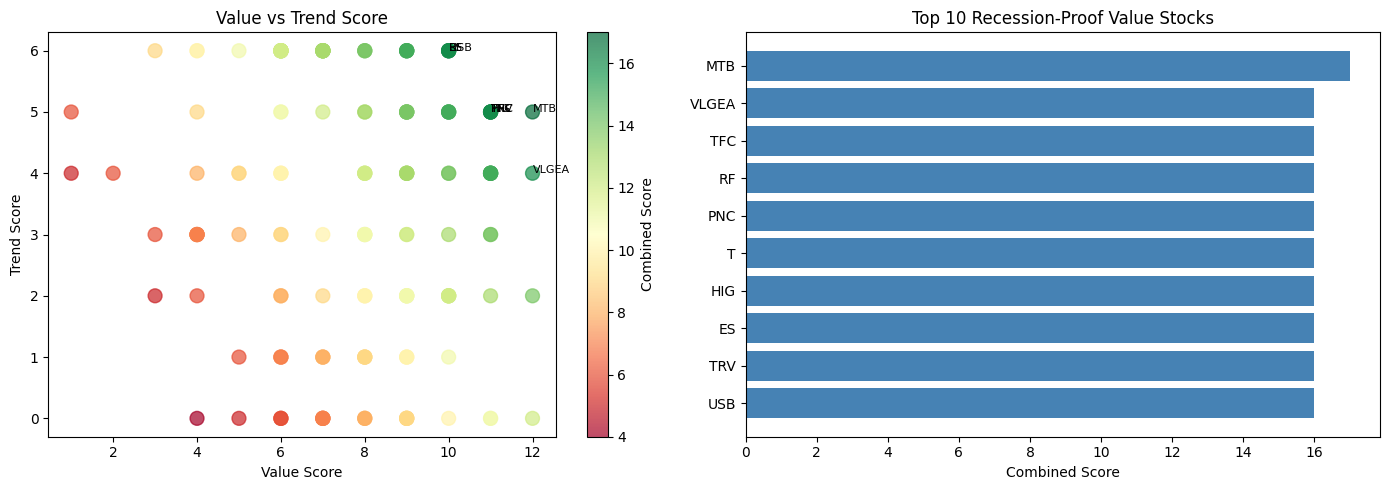

In [8]:
import matplotlib.pyplot as plt

# Get all stocks
all_results = screen_stocks(category=None)

# Plot Value Score vs Trend Score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
ax1 = axes[0]
scatter = ax1.scatter(all_results["value_score"], all_results["trend_score"],
                      c=all_results["combined_score"], cmap="RdYlGn", s=100, alpha=0.7)
for i, row in all_results.head(10).iterrows():
    ax1.annotate(row["symbol"], (row["value_score"], row["trend_score"]), fontsize=8)
ax1.set_xlabel("Value Score")
ax1.set_ylabel("Trend Score")
ax1.set_title("Value vs Trend Score")
plt.colorbar(scatter, ax=ax1, label="Combined Score")

# Top 10 by combined score
ax2 = axes[1]
top10 = all_results.head(10)
bars = ax2.barh(top10["symbol"], top10["combined_score"], color="steelblue")
ax2.set_xlabel("Combined Score")
ax2.set_title("Top 10 Recession-Proof Value Stocks")
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

## Add Custom Stocks
Analyze your own stock symbols:

In [14]:
# Add your own symbols to analyze
custom_symbols = ["BBY"]  # <-- ADD YOUR SYMBOLS

custom_results = []
for symbol in custom_symbols:
    print(f"Analyzing {symbol}...")
    data = get_stock_data(symbol)
    if data:
        data["value_score"] = calculate_value_score(data)
        data["trend_score"] = calculate_trend_score(data)
        data["combined_score"] = data["value_score"] + data["trend_score"]
        custom_results.append(data)

custom_df = pd.DataFrame(custom_results).sort_values("combined_score", ascending=False)
custom_df[["symbol", "name", "price", "pe_ratio", "dividend_yield",
           "beta", "1y_return", "combined_score"]]

Analyzing BBY...


,symbol,name,price,pe_ratio,dividend_yield,beta,1y_return,combined_score
0,BBY,"Best Buy Co., Inc.",64.760002,21.376236,5.83,1.433,-21.434775,2
